In [2]:
#  !pip install underthesea
#  !pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.2 MB/s eta 0:00:00


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import string
from underthesea import word_tokenize
from underthesea import text_normalize
import nltk
import wordcloud
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import resample
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler

In [2]:
df = pd.read_csv('/content/comments_data.csv')
df.head()

,id,title,content,thank_count,customer_id,rating,created_at,customer_name,purchased_at
0,NaN,Cực kì hài lòng,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,0,30287322,5,1742634561,Hoàng Minh,1.742396e+09
1,NaN,Cực kì hài lòng,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",0,30327032,5,1742385565,Mai Dũng,1.742204e+09
2,NaN,Cực kì hài lòng,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,0,30287322,5,1742634561,Hoàng Minh,1.742396e+09
3,NaN,Cực kì hài lòng,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",0,30327032,5,1742385565,Mai Dũng,1.742204e+09
4,NaN,Rất không hài lòng,Airpods mới dùng đã hư. Chính sách bảo hành lò...,0,15223358,1,1743002964,Pham Ngoc Huyen,1.742183e+09


In [3]:
df.shape

(34808, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34808 entries, 0 to 34807
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             0 non-null      float64
 1   title          34808 non-null  object 
 2   content        18329 non-null  object 
 3   thank_count    34808 non-null  int64  
 4   customer_id    34808 non-null  int64  
 5   rating         34808 non-null  int64  
 6   created_at     34808 non-null  int64  
 7   customer_name  34790 non-null  object 
 8   purchased_at   34802 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 2.4+ MB


In [5]:
df.drop(['id'], axis=1, inplace=True)

In [6]:
df.describe()

,thank_count,customer_id,rating,created_at,purchased_at
count,34808.000000,3.480800e+04,34808.000000,3.480800e+04,3.480200e+04
mean,0.339922,1.248825e+07,4.546196,1.678761e+09,1.676434e+09
std,3.078819,8.728273e+06,1.038707,3.951077e+07,3.922055e+07
min,0.000000,2.700000e+01,1.000000,1.412468e+09,1.400236e+09
25%,0.000000,6.053798e+06,5.000000,1.651545e+09,1.649996e+09
50%,0.000000,1.128167e+07,5.000000,1.677936e+09,1.675608e+09
75%,0.000000,1.913384e+07,5.000000,1.710921e+09,1.708489e+09
max,193.000000,3.037014e+07,5.000000,1.746623e+09,1.746542e+09


In [7]:
df['purchased_date'] = pd.to_datetime(df['purchased_at'], unit='s')

# Tùy chọn: hiển thị theo định dạng dd/mm/yyyy
df['purchased_date'] = df['purchased_date'].dt.strftime('%d/%m/%Y')
df

,title,content,thank_count,customer_id,rating,created_at,customer_name,purchased_at,purchased_date
0,Cực kì hài lòng,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,0,30287322,5,1742634561,Hoàng Minh,1.742396e+09,19/03/2025
1,Cực kì hài lòng,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",0,30327032,5,1742385565,Mai Dũng,1.742204e+09,17/03/2025
2,Cực kì hài lòng,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,0,30287322,5,1742634561,Hoàng Minh,1.742396e+09,19/03/2025
3,Cực kì hài lòng,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",0,30327032,5,1742385565,Mai Dũng,1.742204e+09,17/03/2025
4,Rất không hài lòng,Airpods mới dùng đã hư. Chính sách bảo hành lò...,0,15223358,1,1743002964,Pham Ngoc Huyen,1.742183e+09,17/03/2025
...,...,...,...,...,...,...,...,...,...
34803,Cực kì hài lòng,NaN,0,246797,5,1669132765,Nguyễn Quốc Minh Thức,1.668920e+09,20/11/2022
34804,Hài lòng,NaN,0,2174894,4,1665290129,Lê Trung Tuyến,1.665247e+09,08/10/2022
34805,Cực kì hài lòng,NaN,0,15983903,5,1656743750,Gia Bảo,1.656735e+09,02/07/2022
34806,Cực kì hài lòng,NaN,0,19655996,5,1653655694,Minh Phúc,1.652790e+09,17/05/2022


In [8]:
df.drop(['purchased_at', 'thank_count'], axis=1, inplace=True)

In [9]:
df['created_at'] = pd.to_datetime(df['created_at'], unit='s').dt.strftime('%d/%m/%Y')

In [10]:
df.head()

,title,content,customer_id,rating,created_at,customer_name,purchased_date
0,Cực kì hài lòng,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,30287322,5,22/03/2025,Hoàng Minh,19/03/2025
1,Cực kì hài lòng,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",30327032,5,19/03/2025,Mai Dũng,17/03/2025
2,Cực kì hài lòng,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,30287322,5,22/03/2025,Hoàng Minh,19/03/2025
3,Cực kì hài lòng,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",30327032,5,19/03/2025,Mai Dũng,17/03/2025
4,Rất không hài lòng,Airpods mới dùng đã hư. Chính sách bảo hành lò...,15223358,1,26/03/2025,Pham Ngoc Huyen,17/03/2025


In [11]:
df.isnull().sum()

,0
title,0
content,16479
customer_id,0
rating,0
created_at,0
customer_name,18
purchased_date,6


### Có thể thấy cột content thiếu rất nhiều, ta sẽ cân nhắc có nên sử dụng cột title để fill vào cột này không. Nguyên tắc phải đảm bảo cảm xúc phải tương đương, ví dụ: 'title' == Cực kì hài lòng	=> rating = 5

Kiểm tra các giá trị ở trong cột title

In [12]:
df[df['content'].isnull()][['title', 'rating']].value_counts()

,,count
title,rating,
Cực kì hài lòng,5,14374
Hài lòng,4,2052
Bình thường,3,25
Hài lòng,5,19
Cực kì hài lòng,4,6
Rất không hài lòng,1,2
Không hài lòng,2,1


có thể thấy title khá tương ứng với rating mà người dùng đã đánh giá, suy ra có thể sử dụng cột title

### Để khách quan hơn, ta tiến hành tạo trường full_text = title + content (nếu có)

In [13]:
def combine_title_content(row):
    if pd.isna(row['content']) or row['content'].strip() == "":
        return ""  # Nếu content rỗng hoặc NaN, trả về chuỗi rỗng
    else:
        return row['content']  # Chỉ trả về nội dung từ cột 'content'

df['full_text'] = df.apply(combine_title_content, axis=1)

In [14]:
df = df.dropna(subset=['full_text'])

sau khi gộp thành cột full_text, ta tiến hành xoá 2 cột title và content vì:
- Đã trích xuất tất cả thông tin cần thiết từ 2 cột này
- Nhằm giảm nhiễu khi huấn luyện mô hình

In [15]:
df.drop(['title', 'content'], axis=1, inplace=True)
df.head()

,customer_id,rating,created_at,customer_name,purchased_date,full_text
0,30287322,5,22/03/2025,Hoàng Minh,19/03/2025,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...
1,30327032,5,19/03/2025,Mai Dũng,17/03/2025,"Nghe rất đã, mic hút, hàng chính hãng nên cũng..."
2,30287322,5,22/03/2025,Hoàng Minh,19/03/2025,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...
3,30327032,5,19/03/2025,Mai Dũng,17/03/2025,"Nghe rất đã, mic hút, hàng chính hãng nên cũng..."
4,15223358,1,26/03/2025,Pham Ngoc Huyen,17/03/2025,Airpods mới dùng đã hư. Chính sách bảo hành lò...


Tiếp theo, ta tiến hành xoá bỏ biểu tượng cảm xúc trong data

In [16]:
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF"
                u"\U0001F680-\U0001F6FF"
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE) # Unicode emojis.

def clean_text(text):
    text = text.lower() # lowercase text

    text = re.sub(emoji_pattern, " ", text) # remove emojis

    text = re.sub(r'([a-z]+?)\1+',r'\1', text) # reduce repeated character (e.g. 'aaabbb' -> 'ab')

    # Ensure space before and after any punctuation mark
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)

    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+",r"\1", text) # reduce consecutive punctuation

    # Remove any leading or trailing spaces, or leading or trailing punctuation marks from the text
    text = text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]

    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuation

    text = re.sub(r"\s+", " ", text) # reduce multiple spaces

    text = text_normalize(text) # make sure punctunation is in the right letter (Vietnamese case)
    text = word_tokenize(text, format="text") # tokenize the cleaned text
    return text

In [17]:
df['corpus'] = df['full_text'].map(lambda text: clean_text(text))
# Final check
df.head(20)

,customer_id,rating,created_at,customer_name,purchased_date,full_text,corpus
0,30287322,5,22/03/2025,Hoàng Minh,19/03/2025,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,hàng giao_siêu nhanh đóng_gói chỉn chu_ko móp_...
1,30327032,5,19/03/2025,Mai Dũng,17/03/2025,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",nghe rất đã mic hút hàng chính hãng nên cũng y...
2,30287322,5,22/03/2025,Hoàng Minh,19/03/2025,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,hàng giao_siêu nhanh đóng_gói chỉn chu_ko móp_...
3,30327032,5,19/03/2025,Mai Dũng,17/03/2025,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",nghe rất đã mic hút hàng chính hãng nên cũng y...
4,15223358,1,26/03/2025,Pham Ngoc Huyen,17/03/2025,Airpods mới dùng đã hư. Chính sách bảo hành lò...,airpods mới dùng đã hư chính_sách bảo_hành lòn...
5,15532413,5,05/04/2025,Gia Khương Trương,03/04/2025,"Giao hàng rất nhanh, đúng hẹn, sản phẩm mới xà...",giao hàng rất nhanh đúng hẹn sản_phẩm mới xài ...
6,8726469,5,11/11/2024,Nguyen Tan Loc,10/11/2024,"Good chính hãng,xài ngon lành nha mọi người",god chính hãng xài ngon_lành_nha mọi người
7,8702212,1,26/03/2025,Phi Hoang Diep,25/03/2025,Sản phẩm mua ngày 26/3/2025 mà hạn bảo hành có...,sản_phẩm mua ngày 26 3 2025 mà hạn bảo_hành có...
8,16473324,5,13/12/2024,lam nguyen,13/12/2024,Hàng còn nguyên seal. Luôn an tâm mua của tiki...,hàng còn nguyên_seal luôn an_tâm mua của tiki ...
9,746760,5,12/12/2024,Quốc Hùng,12/12/2024,Product’s very good!!! Excellent sound quality...,product’s very god excelent sound quality efec...


#### Tạo nhãn cho các comment: 1,2 sao = 0; 3 sao = 1, 4,5 sao = 2;

In [18]:
def get_label(rating):
    if rating in [1, 2]:
        return 0
    elif rating == 3:
        return 1
    elif rating in [4, 5]:
        return 2

# Tạo cột mới 'label' trong DataFrame
df['label'] = df['rating'].apply(get_label)
df.drop(['rating'], axis=1, inplace=True)
df.head()

,customer_id,created_at,customer_name,purchased_date,full_text,corpus,label
0,30287322,22/03/2025,Hoàng Minh,19/03/2025,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,hàng giao_siêu nhanh đóng_gói chỉn chu_ko móp_...,2
1,30327032,19/03/2025,Mai Dũng,17/03/2025,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",nghe rất đã mic hút hàng chính hãng nên cũng y...,2
2,30287322,22/03/2025,Hoàng Minh,19/03/2025,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,hàng giao_siêu nhanh đóng_gói chỉn chu_ko móp_...,2
3,30327032,19/03/2025,Mai Dũng,17/03/2025,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",nghe rất đã mic hút hàng chính hãng nên cũng y...,2
4,15223358,26/03/2025,Pham Ngoc Huyen,17/03/2025,Airpods mới dùng đã hư. Chính sách bảo hành lò...,airpods mới dùng đã hư chính_sách bảo_hành lòn...,0


Number of words: 12548
Most common words: [('ok', 533), ('tốt', 333), ('god', 113), ('rất tốt', 59), ('sản_phẩm tốt', 55), ('đẹp', 48), ('chất_lượng tốt', 37), ('ngon', 35), ('hàng tốt', 35), ('ổn', 35), ('giao hàng nhanh', 34), ('hài_lòng', 32), ('tuyệt_vời', 31), ('sản_phẩm ok', 29), ('rất hài_lòng', 29)]


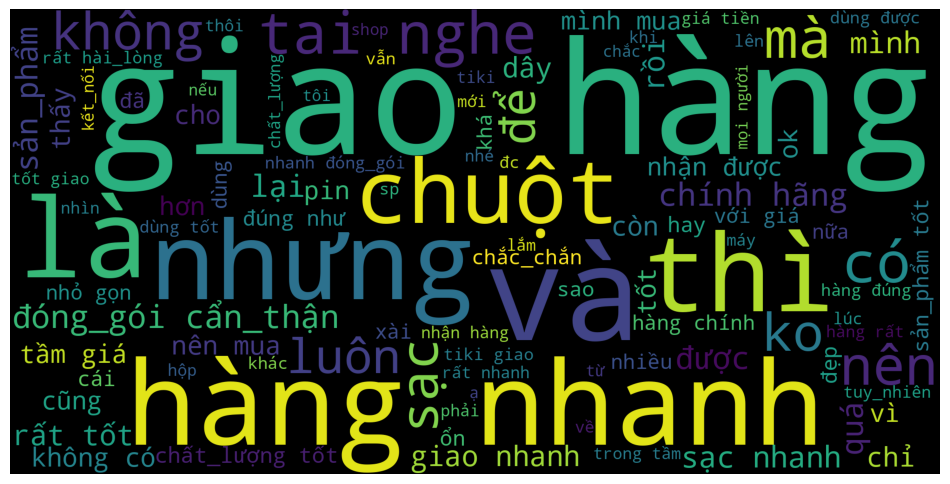

In [19]:
all_words = [token for token in df['corpus'].tolist() if token and token != '']

corpus=' '.join(all_words)
all_words = nltk.FreqDist(all_words)

# Print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

plt.figure(figsize=(12,8))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(corpus)
plt.axis("off")
plt.imshow(word_cloud)

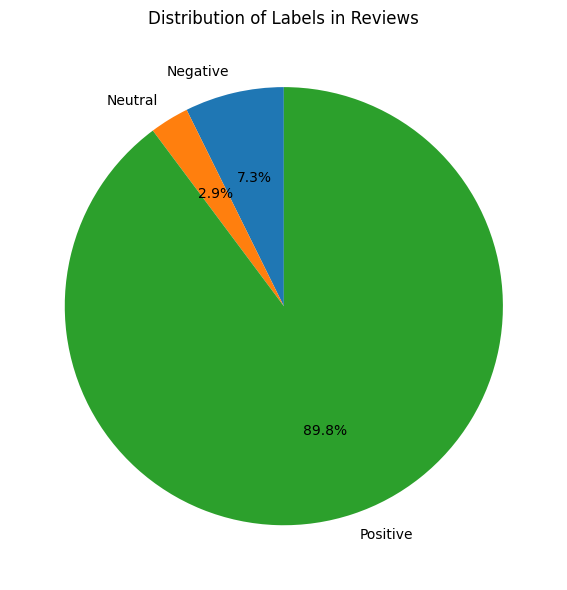

In [20]:
# Count the occurrences of each label
label_counts = df['label'].value_counts().sort_index()

# Pie chart cho labels
labels = ['Negative', 'Neutral', 'Positive']  # updated labels
fig, ax = plt.subplots(figsize=(6, 6))  # chỉ tạo 1 biểu đồ
ax.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Labels in Reviews')

plt.tight_layout()
plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    df['corpus'],
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

In [22]:
train_df = pd.DataFrame({'corpus': X_train, 'label': y_train})
train_df.to_csv('train_df.csv', index=False)
test_df = pd.DataFrame({'corpus': X_test, 'label': y_test})
test_df.to_csv('test_df.csv', index=False)

In [23]:
train_df = pd.DataFrame({'corpus': X_train, 'label': y_train})

df_0 = train_df[train_df['label'] == 0]
df_1 = train_df[train_df['label'] == 1]
df_2 = train_df[train_df['label'] == 2]

target_samples = int(0.5 * len(df_2))

df_0_upsampled = resample(df_0,
                          replace=True,
                          n_samples=target_samples,
                          random_state=42)

df_1_upsampled = resample(df_1,
                          replace=True,
                          n_samples=target_samples,
                          random_state=42)

train_balanced = pd.concat([df_0_upsampled, df_1_upsampled, df_2])

train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Tách lại X_train, y_train
X_train_balanced = train_balanced['corpus']
y_train_balanced = train_balanced['label']

In [24]:
unique_labels, counts = np.unique(y_train_balanced, return_counts=True)

# Display the distribution
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

Label 0: 12502
Label 1: 12502
Label 2: 25004


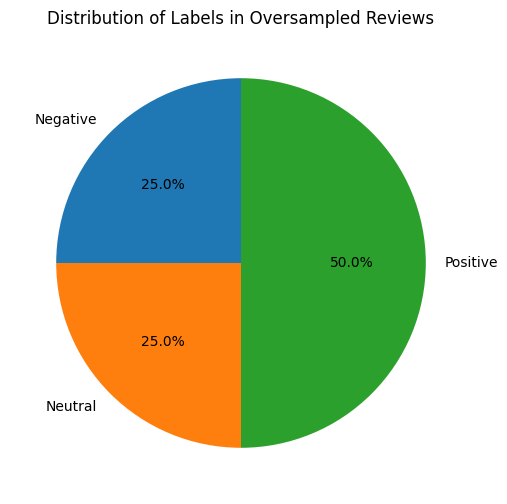

In [25]:
label_counts_oversampled = pd.Series(y_train_balanced).value_counts().sort_index()
labels = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(6, 6))
plt.pie(label_counts_oversampled, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Labels in Oversampled Reviews')
plt.show()

## Text vectorizer

In [27]:
# Initialize the CountVectorizer
stop_words_vi = ['và', 'của', 'là', 'trong', 'có', 'với', 'là', 'theo']

vectorizer = CountVectorizer(max_features=5000, stop_words=stop_words_vi)


X_train_vec = vectorizer.fit_transform(X_train_balanced)
X_test_vec = vectorizer.transform(X_test)

### Sử dụng K-Fold để tìm ra tham số đẹp nhất

In [32]:
knn_model = KNeighborsClassifier()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'n_neighbors': [2, 3, 4],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Sử dụng GridSearchCV để tìm tham số tốt nhất
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=kf, scoring='f1_macro')

# Huấn luyện và tìm tham số tối ưu
grid_search.fit(X_train_vec, y_train_balanced)

# In ra kết quả tìm kiếm tốt nhất
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.9824


In [28]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan')
knn.fit(X_train_vec, y_train_balanced)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [33]:
import joblib

joblib.dump(knn, 'KNeighborsClassifier.pkl')

['KNeighborsClassifier.pkl']

In [29]:
y_pred = knn.predict(X_test_vec)  # Dự đoán trên bộ dữ liệu kiểm tra

In [30]:
# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

# In kết quả đánh giá
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

Accuracy: 0.9357
F1 Score: 0.6836
Recall: 0.6471
Precision: 0.7338


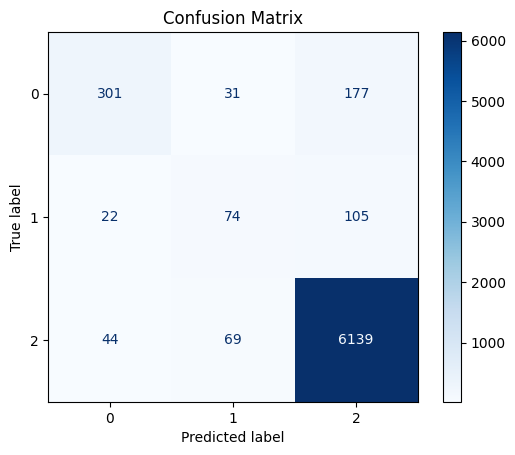

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels = [0, 1, 2])

# Hiển thị
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [32]:
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

Accuracy: 0.9357
F1 Score: 0.6836
Recall: 0.6471
Precision: 0.7338


### Nhận xét:

#### Nhìn chung mô hình này cho thấy hiệu suất không đồng đều giữa các lớp, với hiệu suất vượt trội ở lớp 2 nhưng gặp khó khăn trong việc phân loại chính xác các mẫu thuộc lớp 0 và lớp 1

- Nguyên nhân: Dữ liệu bị mất cân bẳng với những mẫu thuộc lớp 0 và 1